## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Developed the classifier model. 


Steps:
- Exploration
- Cleaning
- Feature Engineering
- Modeling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
df = pd.read_csv("train.csv",index_col=None)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

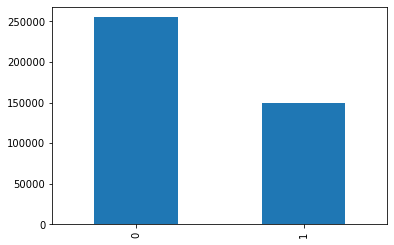

In [6]:
df["is_duplicate"].value_counts().plot(kind='bar')
plt.show()

In [7]:
# Percentage of questions duplicate or not
print("Question pairs are not Similar (is_duplicate = 0):  {}%".format(100 - round(df["is_duplicate"].mean()*100,2)))
print("Question pairs are Similar (is_duplicate =1):   {}%".format(round(df["is_duplicate"].mean()*100,2)))

Question pairs are not Similar (is_duplicate = 0):  63.08%
Question pairs are Similar (is_duplicate =1):   36.92%


In [8]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total Number of questions',qid.shape[0])
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Total Number of questions 808580
Number of unique questions 537933
Number of questions getting repeated 111780


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [3]:
# What punctuation is included in the default list?
import string
string.punctuation

def remove_punct(text):
    text = "".join([c for c in str(text) if c not in string.punctuation])
    return text

In [4]:
df['Questions_1'] = df['question1'].apply(lambda x: remove_punct(x))
df['Questions_2'] = df['question2'].apply(lambda x: remove_punct(x))

df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,Questions_1,Questions_2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,Astrology I am a Capricorn Sun Cap moon and ca...,Im a triple Capricorn Sun Moon and ascendant i...
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,Should I buy tiago,What keeps childern active and far from phone ...
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,How can I be a good geologist,What should I do to be a great geologist
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,When do you use シ instead of し,When do you use instead of and
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,Motorola company Can I hack my Charter Motorol...,How do I hack Motorola DCX3400 for free internet


In [32]:
df.drop(['question1', 'question2'], axis=1,inplace=True)
df

,id,qid1,qid2,is_duplicate,Questions_1,Questions_2,Question1_tokenized
0,0,1,2,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,0,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,"[what, would, happen, if, the, indian, governm..."
2,2,5,6,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,"[how, can, internet, speed, be, increased, by,..."
3,3,7,8,0,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divided ...,"[find, the, remainder, when, 23, 24, math, is,..."
4,4,9,10,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,"[which, fish, would, survive, in, salt, water]"
...,...,...,...,...,...,...,...
404285,404285,433578,379845,0,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,"[how, many, keywords, are, there, in, perl, pr..."
404286,404286,18840,155606,1,do you believe there is life after death,is it true that there is life after death,"[is, it, true, that, there, is, life, after, d..."
404287,404287,537928,537929,0,what is one coin,what is this coin,"[what, is, this, coin]"
404288,404288,537930,537931,0,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,"[i, am, having, little, hairfall, problem, but..."


In [5]:
# Define a function to split our sentences into a list of words
# ['Define', 'a', 'function', ...]

#import regular expression
import re

def tokenize(text):
    tokens = text.split()
    return tokens

df['Question1_tokenized'] = df['Questions_1'].apply(lambda x: tokenize(x.lower()))
df['Question2_tokenized'] = df['Questions_2'].apply(lambda x: tokenize(x.lower()))

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Questions_1,Questions_2,Question1_tokenized,Question2_tokenized
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math2324math, is,..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]"


In [6]:
# Import the NLTK package and download the necessary data
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# view the stopwords
stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [7]:
#We want to only use their english stopwords
ENGstopwords = stopwords.words('english')
# Define a function to remove all stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

df['Questions_1_nostop'] = df['Question1_tokenized'].apply(lambda x: remove_stopwords(x))
df['Questions_2_nostop'] = df['Question2_tokenized'].apply(lambda x: remove_stopwords(x))

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Questions_1,Questions_2,Question1_tokenized,Question2_tokenized,Questions_1_nostop,Questions_2_nostop
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math2324math, is,...","[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [118]:
df.drop(['ques1_lemi', 'ques2_lemi'], axis=1,inplace=True)

In [8]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

df["Questions_1_lemi"] = df["Questions_1_nostop"].apply(lambda text: lemmatize_words(text))
df["Questions_2_lemi"] = df["Questions_2_nostop"].apply(lambda text: lemmatize_words(text))

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate,Questions_1,Questions_2,Question1_tokenized,Question2_tokenized,Questions_1_nostop,Questions_2_nostop,Questions_1_lemi,Questions_2_lemi
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math2324math, is,...","[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",mentally lonely solve,find remainder math2324math divided 2423
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [28]:
df11 = list(df['Questions_1_lemi'])
df12 = list(df['Questions_1_lemi'])

['step step guide invest share market india',
 'story kohinoor kohinoor diamond',
 'increase speed internet connection using vpn',
 'mentally lonely solve',
 'one dissolve water quikly sugar salt methane carbon di oxide',
 'astrology capricorn sun cap moon cap risingwhat say',
 'buy tiago',
 'good geologist',
 'use シ instead し',
 'motorola company hack charter motorolla dcx3400',
 'method find separation slit using fresnel biprism',
 'read find youtube comment',
 'make physic easy learn',
 'first sexual experience like',
 'law change status student visa green card u compare immigration law canada',
 'would trump presidency mean current international master’s student f1 visa',
 'manipulation mean',
 'girl want friend guy reject',
 'many quora user posting question readily answered google',
 'best digital marketing institution banglore',
 'rocket look white',
 'whats causing someone jealous',
 'question ask quora',
 'much 30 kv hp',
 'mean every time look clock number',
 'tip making job 

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [9]:
# merge texts
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['Questions_1_lemi']) + list(df['Questions_1_lemi'])

cv = CountVectorizer(max_features=300)
q1, q2 = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [10]:
df1 = pd.DataFrame(q1, index= df.index)
df2 = pd.DataFrame(q2, index= df.index)
temp_df = pd.concat([df1, df2], axis=1)
temp_df.shape

(404290, 600)

In [11]:
temp_df['is_duplicate'] = df['is_duplicate']

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)


In [19]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
xgb = xgb.XGBClassifier(n_jobs= -1, max_depth=10, learning_rate=0.1, subsample = 0.8, min_child_weight=3)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.6947364515570507

In [25]:
# Trying LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Embedding,LSTM,concatenate

In [27]:
vocab_size=20000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(questions)

In [29]:
max_length=100
sequence1=tokenizer.texts_to_sequences(df11)
sequence1=pad_sequences(sequence1,maxlen=max_length,padding='post')
sequence2=tokenizer.texts_to_sequences(df12)
sequence2=pad_sequences(sequence2,maxlen=max_length,padding='post')

In [32]:
from tensorflow.keras import Input

text_input1=Input(shape=(None,),dtype='int32')
embedding1=Embedding(vocab_size,64)(text_input1)
encoded_text1=LSTM(32)(embedding1)

text_input2=Input(shape=(None,),dtype='int32')
embedding2=Embedding(vocab_size,64)(text_input2)
encoded_text2=LSTM(32)(embedding2)

concatenated=concatenate([encoded_text1,encoded_text2],axis=-1)

output=Dense(64,activation='relu')(concatenated)
output=Dense(1,activation='sigmoid')(output)

In [33]:
model=Model([text_input1,text_input2],output)
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
target=np.asarray(df['is_duplicate'])
model.fit([sequence1,sequence2],target,epochs=10,batch_size=128)

Epoch 1/10
3159/3159 [==============================] - 381s 121ms/step - loss: 0.6589 - accuracy: 0.6308
Epoch 2/10
3159/3159 [==============================] - 392s 124ms/step - loss: 0.6587 - accuracy: 0.6308
Epoch 3/10
3159/3159 [==============================] - 403s 128ms/step - loss: 0.6587 - accuracy: 0.6308
Epoch 4/10
3159/3159 [==============================] - 476s 151ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 5/10
3159/3159 [==============================] - 444s 140ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 6/10
3159/3159 [==============================] - 436s 138ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 7/10
3159/3159 [==============================] - 430s 136ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 8/10
3159/3159 [==============================] - 478s 151ms/step - loss: 0.6587 - accuracy: 0.6308
Epoch 9/10
3159/3159 [==============================] - 473s 150ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 10/10
3159/3159 [=======================